In [60]:
import pandahouse as ph
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
import tensorflow_probability as tfp

import causalimpact
from causalimpact import CausalImpact

Очевидно, при проведении флэшмоба должна увеличиться CTR, поскольку теперь лайки играют бОльшую роль и определяют победителя, в таком случае пользователи часто обмениваются лайками для взаимного продвижения, при этом, возможно, увеличится просто пользовательская активность - будем смотреть по просмотрам на одного пользователя - вероятно, участники флэшмоба будут следить за постами конкурентов. Во-вторых, должно увеличится количество выкладываемых постов за день. (Правда, в наших данных мы можем узнать только, когда было совершено первое действие относительно поста). В-третьих, хотелось бы, чтобы увеличилась дневная активная аудитория - то есть пользователи, ранее редко пользовавшиеся приложениям, стали более активными благодаря флэшмобу. Итого, наши 5 метрик: CTR, просмотры на пользователя, кол-во новых постов, DAU и новые пользователи.

Будем считать данные за 5 недель. За 4 недели до флэшмоба, и саму неделю флэшмоба.

In [29]:
#устонавливаем соединение
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20240720'
}


#Делаем запросы в ClickHouse
q_user_activity = """
with t1 as (SELECT user_id,
    toDate(time) as date, 
    sum(action = 'like') as likes,
    sum(action = 'view') as views
FROM simulator_20240720.feed_actions
WHERE toDate(time) >= '2024-06-14' and toDate(time) <= '2024-07-18' 
GROUP BY user_id, date
ORDER BY date, user_id)

SELECT date, 
       avg(likes) as likes,
       avg(views) as views,
       likes/views as ctr
FROM t1
GROUP BY date
"""


q_new_posts = """
with t1 as (SELECT post_id,
             user_id,
             action,
             time,
             min(time) OVER(PARTITION BY post_id) as time_created
      FROM simulator_20240720.feed_actions
      WHERE toDate(time) >= '2024-06-14' and toDate(time) <= '2024-07-18' )
SELECT toDate(time_created) as date_created,
       count(DISTINCT post_id) as new_posts
FROM t1
GROUP BY date_created
"""


q_DAU = """
SELECT toDate(time) as date,
       uniqExact(user_id) as DAU    
FROM {db}.feed_actions
WHERE toDate(time) >= '2024-06-14' and toDate(time) <= '2024-07-18' 
GROUP BY date
"""

q_new_users = """
with t1 as (SELECT user_id, post_id, action, time, min(time) OVER(partition by user_id) as first_action
FROM simulator_20240720.feed_actions
WHERE toDate(time) >= '2024-06-14' and toDate(time) <= '2024-07-18' )

SELECT first_action::date as user_entry_date, count(DISTINCT user_id) as new_users
FROM t1
GROUP BY first_action::date
ORDER BY first_action::date

"""

#Загружаем данные в DataFrame
df_user_activity = ph.read_clickhouse(q_user_activity, connection = connection)
df_new_posts = ph.read_clickhouse(q_new_posts, connection = connection)
df_DAU = ph.read_clickhouse(q_DAU, connection = connection)
df_new_users = ph.read_clickhouse(q_new_users, connection = connection)



In [28]:
#df_user_activity

In [45]:
# Строим модели для каждого эффекта 
impact_CTR = CausalImpact(data=df_user_activity['ctr'], #данные
                      pre_period=[0, 27], #период до флэшмоба
                      post_period = [28, 34],
                      model_args = {'nseasons': 7}) #период флэшмоба
impact_views = CausalImpact(data=df_user_activity['views'], #данные
                      pre_period=[0, 27], #период до флэшмоба
                      post_period = [28, 34]) #период флэшмоба
impact_new_posts = CausalImpact(data=df_new_posts['new_posts'], #данные
                      pre_period=[0, 27], #период до флэшмоба
                      post_period = [28, 34]) #период флэшмоба
impact_DAU = CausalImpact(data=df_DAU['DAU'], #данные
                      pre_period=[0, 27], #период до флэшмоба
                      post_period = [28, 34]) #период флэшмоба
impact_new_users = CausalImpact(data=df_new_users['new_users'], #данные
                      pre_period=[0, 27], #период до флэшмоба
                      post_period = [28, 34]) #период флэшмоба

2024-08-30 13:49:05.308400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-30 13:49:05.325026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-08-30 13:49:05.851770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-30 13:

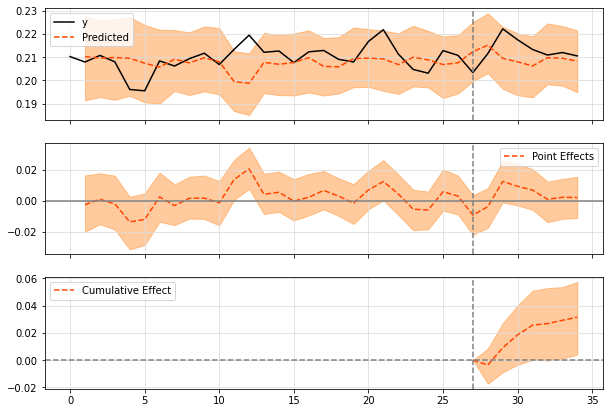

"Posterior Inference {Causal Impact}\n                          Average            Cumulative\nActual                    0.21               1.5\nPrediction (s.d.)         0.21 (0.0)         1.47 (0.01)\n95% CI                    [0.21, 0.21]       [1.44, 1.49]\n\nAbsolute effect (s.d.)    0.0 (0.0)          0.03 (0.01)\n95% CI                    [0.0, 0.01]        [0.0, 0.06]\n\nRelative effect (s.d.)    2.15% (0.94%)      2.15% (0.94%)\n95% CI                    [0.28%, 3.97%]     [0.28%, 3.97%]\n\nPosterior tail-area probability p: 0.01\nPosterior prob. of a causal effect: 98.7%\n\nFor more details run the command: print(impact.summary('report'))"

In [46]:
impact_CTR.plot()
impact_CTR.summary()

На графике кумулятивного эффекта можно увидеть, что на CTR был оказан статистически незначимый положительный эффект, если учитывать, что за весь период до флэшмоба он менялся крайне незначительно. Таким образом, изначальная гипотеза о взаимных лайках выглядит разумной, но скорее всего, такие люди не составляют значимого процента от аудитории.

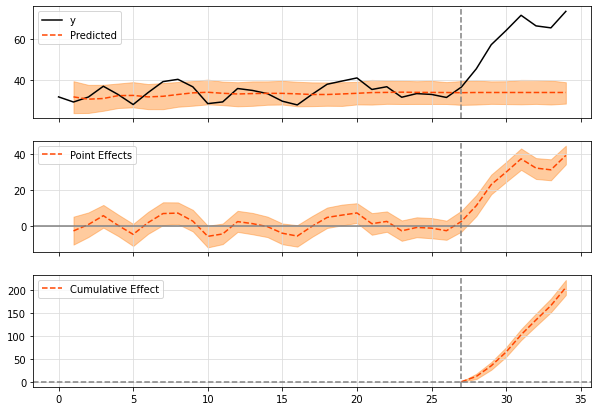

"Posterior Inference {Causal Impact}\n                          Average            Cumulative\nActual                    63.21              442.5\nPrediction (s.d.)         33.79 (1.19)       236.56 (8.32)\n95% CI                    [31.49, 36.15]     [220.41, 253.02]\n\nAbsolute effect (s.d.)    29.42 (1.19)       205.94 (8.32)\n95% CI                    [27.07, 31.73]     [189.48, 222.09]\n\nRelative effect (s.d.)    87.06% (3.52%)     87.06% (3.52%)\n95% CI                    [80.1%, 93.89%]    [80.1%, 93.89%]\n\nPosterior tail-area probability p: 0.0\nPosterior prob. of a causal effect: 100.0%\n\nFor more details run the command: print(impact.summary('report'))"

In [43]:
impact_views.plot()
impact_views.summary()

На графике просмотров мы видим крайне значительный эффект относительно предыдущих изменений. Похоже, часть пользователей сильно вовлеклисьь во флэшмоб, и регулярно просматривали посты конкурентов, чтобы оценивать свои шансы на призы.

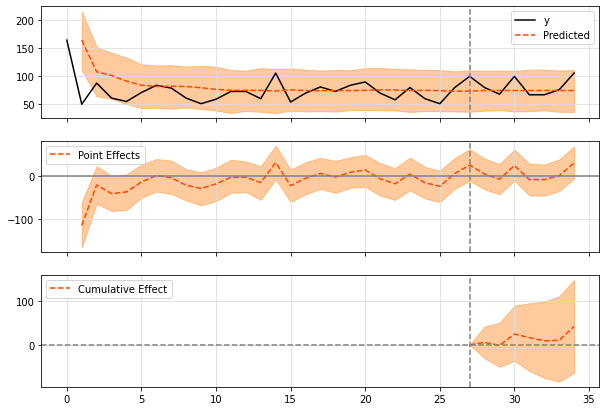

In [39]:
impact_new_posts.plot()

А вот на количество постов эффект был оказан незначительный. Похоже, это связано с тем, что пользователи, учавствуещие во лэшмобе, были вовлечены в улучшение тематических постов, и соответсвенно, меньше выкляадывали посты на другую тематику.

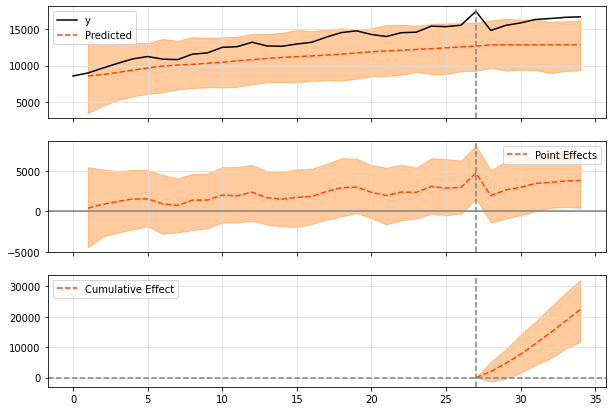

In [33]:
impact_DAU.plot()

На дневную аудиторию также был оказан значимый эффект, похоже, наша изначальная гипотеза тоже была верна. 

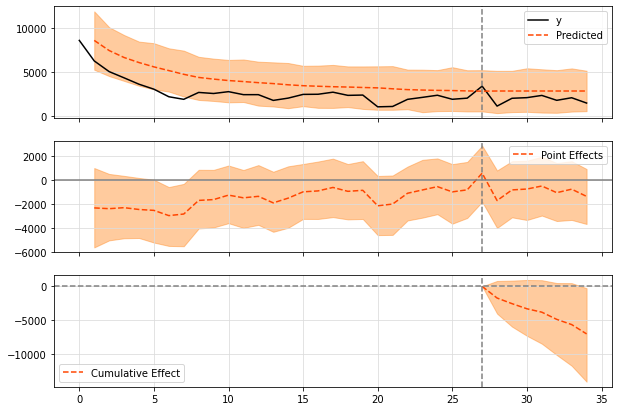

In [37]:
impact_new_users.plot()

А вот на новых пользователей был оказан отрицательный эффект, который может быть вызван случайными колебаниями, однако всё же явно прослеживается, и учитывая, что мы ожидали обратный эффект, стоит это осмыслить. Можно предположить, что для новых пользователей бОльший интерес представляют новостные посты, чем посты незнакомых людей о себе, а в результате флэшмоба их лента была "засорена". Также, возможно, значительная часть ресурсов маркетологов ушла именно на проведение флэшмоба, и меньше внимания уделялось привлечению новых пользователей. 


<H3>Вывод</H3>
Итого, в целом рекламная компания прошла неплохо, основные целевые показатели выросли, нам действительно удалось завлечь часть пользователей флэшмобом. Однако, в будущем стоило бы сделать тематику флэшмоба более интересной для новых пользователей, а также стимулировать участников выкладывать много постов (например, какие-то ежедневные отчёты о достижениях), чтобы "обновляемость" ленты также увеличивалась. 

Теперь попробуем проанализировать долгосрочные эффекты для моделей со статистически значимыми изменениями.

In [71]:
#тренд


data_views = df_user_activity['views'].astype(np.float32)
data_DAU = df_DAU.drop("date", axis=1).astype(np.float32)

#стандартизуем
mean = np.mean(data_views)
std_dev = np.std(data_views)
standartized_data_views = (data_views - mean)/std_dev
obs_data_views = standartized_data_views.iloc[:28]


mean = np.mean(data_views)
std_dev = np.std(data_views)
standartized_data_DAU = (data_views - mean)/std_dev
obs_data_DAU = standartized_data_DAU.iloc[:28]


trend_component_views = tfp.sts.LocalLinearTrend(observed_time_series=obs_data_views)
trend_component_DAU = tfp.sts.LocalLinearTrend(observed_time_series=obs_data_DAU)




In [76]:
impact_views_trend = CausalImpact(data=df_user_activity['views'], #данные
                      pre_period=[0, 27], #период до флэшмоба
                      post_period = [28, 34], #период флэшмоба
                      model_args = {'nseasons': 7},
                      model = trend_component_views) 

impact_DAU_trend = CausalImpact(data=df_DAU['DAU'], #данные
                      pre_period=[0, 27], #период до флэшмоба
                      post_period = [28, 34], #период флэшмоба
                      model_args = {'nseasons': 7},
                      model = trend_component_DAU) 

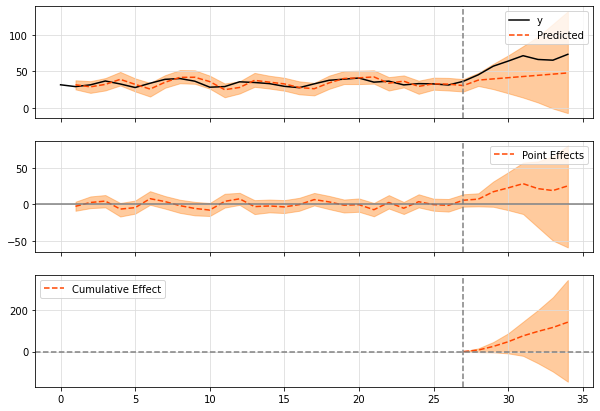

"Posterior Inference {Causal Impact}\n                          Average            Cumulative\nActual                    63.21              442.5\nPrediction (s.d.)         42.96 (18.84)      300.71 (131.87)\n95% CI                    [11.51, 85.36]     [80.59, 597.53]\n\nAbsolute effect (s.d.)    20.26 (18.84)      141.79 (131.87)\n95% CI                    [-22.15, 51.7]     [-155.03, 361.9]\n\nRelative effect (s.d.)    47.15% (43.85%)    47.15% (43.85%)\n95% CI                    [-51.56%, 120.35%] [-51.56%, 120.35%]\n\nPosterior tail-area probability p: 0.12\nPosterior prob. of a causal effect: 87.71%\n\nFor more details run the command: print(impact.summary('report'))"

In [81]:
impact_views_trend.plot()
impact_views_trend.summary()

Как видим, после ведение тренда эффект оказался не таким значительным и не может быть однозначно признан статистически занчимым из-за короткого срока исследования, так что нужны дыльнейшие наблюдения.